In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# physical and numerical constants
h = 0.1
g = 10
N = 300

def equations(X):
    qu = X[0]
    qa = X[1]
    vu = X[2]
    va = X[3]

    # non controlled motion
    u = 0

    M = np.array([[3 + 2 * np.cos(qa), 1 + np.cos(qa)], [1 + np.cos(qa), 1]])

    b = np.array([u + 2 * np.sin(qa) *va * vu + np.sin(qa) * va**2 - g *( 2 * np.sin(qu) + np.sin(qu+qa)),
               np.sin(qa) * va * vu - g * np.sin(qu + qa)])

    diff_q = np.array([vu, va])
    diff_v = np.linalg.inv(M).dot(b)
    EQ = np.append(diff_q, diff_v)
    return EQ

print('Checking that M.dot(b) is giving [1, 3]: ', np.array([[1, 2], [3, 4]]).dot(np.array([1, 0])))

def runge_kutta_fourth(func, Y, h):
    k1 = func(Y)
    k2 = func(Y + h/2 * k1)
    k3 = func(Y + h/2 * k2)
    k4 = func(Y + h * k3)
    Y_new = Y + h/6 * (k1 + 2 * k2 + 2* k3 + k4)
    return Y_new

def euler(func, Y, h):
    return Y + h * func(Y)

def energy(X):
    qu = X[0]
    qa = X[1]
    v = X[2:4]

    M = np.array([[3 + 2 * np.cos(qa), 1 + np.cos(qa)], [1 + np.cos(qa), 1]])
    V = - g * (2 * np.cos(qu) + np.cos(qu + qa))
    E = v.T.dot(M.dot(v)) + V

    return E

print('Quadratic form ', energy(np.array([0,0, 1, 1])))

X0 = np.array([0, 0, 1, 4])
X = np.zeros((N,4))
EE = np.zeros(N)
X[0] = X0
EE[0] = energy(X0)


for i in range(N-1):
    X[i+1] = runge_kutta_fourth(equations, X[i], h)
    # X[i+1] = euler(equations, X[i], h)
    EE[i+1] = energy(X[i+1])

time = np.linspace(0, (N-1)*h, N)
df = pd.DataFrame(X, columns=['qu', 'qa', 'vu', 'va'])
df['time'] = time
df['energy'] = EE
df.head()

Checking that M.dot(b) is giving [1, 3]:  [1 3]
Quadratic form  -20.0


,qu,qa,vu,va,time,energy
0,0.000000,0.000000,1.000000,4.000000,0.0,7.000000
1,0.113568,0.367619,1.348854,3.150714,0.1,6.476798
2,0.270901,0.620061,1.757475,1.936483,0.2,4.832516
3,0.454256,0.767027,1.856702,1.060934,0.3,1.811631
4,0.632520,0.842933,1.667047,0.504067,0.4,-1.995256


<Axes: xlabel='time'>

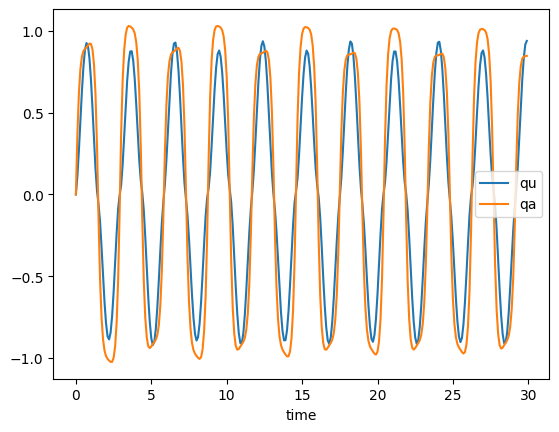

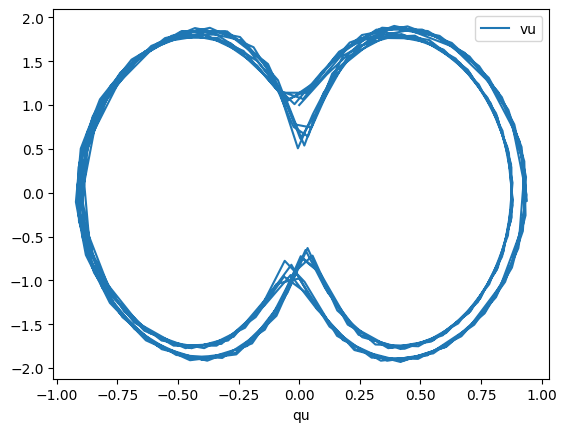

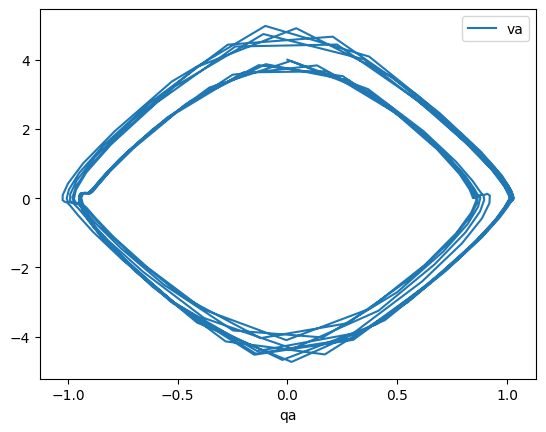

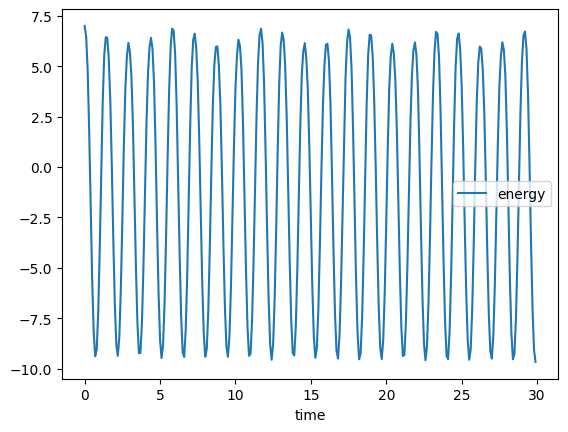

In [2]:
df.plot(x='time', y=['qu', 'qa'])
df.plot(x='qu', y='vu')
df.plot(x='qa', y='va')
df.plot(x='time', y='energy')

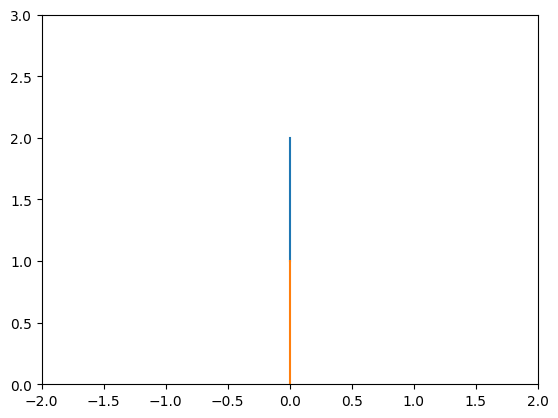

In [4]:
#Make animation
from matplotlib.animation import FuncAnimation, writers
import matplotlib as mpl

fig2 = plt.figure()

lines = plt.plot([])
line = lines[0]
lines2 = plt.plot([])
line2 = lines2[0]
#other setup
plt.xlim(-2, 2)
plt.ylim(0, 3)
# plt.grid()

def animate(k):
    #update plot
    center_x=0
    center_y=2
    x1 = np.array([center_x, center_x + np.sin(X[k,0])])
    y1 = np.array([center_y, center_y - np.cos(X[k,0])])
    x2 = np.array([center_x + np.sin(X[k,0]), center_x + np.sin(X[k,0])+np.sin(X[k,1])])
    y2 = np.array([center_y - np.cos(X[k,0]), center_y - np.cos(X[k,0])-np.cos(X[k,1])])

    line.set_data((x1,y1))
    line2.set_data((x2,y2))

anim = FuncAnimation(fig2,animate,frames=N,interval=N/3)

anim.save('uncontrolled_double_pendulum.mp4')

# Controlled motion

In [5]:
def cos(t):
    return np.cos(t)

def sin(t):
    return np.sin(t)

def control(X):
    qu = X[0]
    qa = X[1]
    vu = X[2]
    va = X[3]

    # control law, computed somewhere else
    u = (2*g*sin(qu)*cos(qa)**2 + g*sin(qu)*cos(qa) - 5*g*sin(qu)/2 - g*sin(qa + qu)*cos(qa)**2 - 3*g*sin(qa + qu)*cos(qa) - 2*g*sin(qa + qu) + g*sin(2*qa + qu)*cos(qa) + 3*g*sin(2*qa + qu)/2 + 2*va*vu*sin(qa)*cos(qa)**2 - va*vu*sin(2*qa)*cos(qa) + va*(va*cos(qa) + va + 2*vu*cos(qa) + 3*vu)**2*cos(qa)**2 - 2*va*(va*cos(qa) + va + 2*vu*cos(qa) + 3*vu)**2 + va*cos(qa)**2 - 2*va)/(cos(qa)**2 - 2)
    # d = 2 - cos(qa)**2
    # u = -1/d * ((2 * np.tan(qa)**2 + 3)*va + 4 * np.sin(va)*(2*vu + va) + g * (np.cos(qa)**2 - 2) * (2*np.sin(qu) + np.sin(qu + qa)))
    return u

# print('Control at [pi/2, 0, 1, 1] ', control(np.array([np.pi/2,  0, 1, 1]))) # 16.902348182305243

def controlled_equations(X):
    qu = X[0]
    qa = X[1]
    vu = X[2]
    va = X[3]

    # controlled motion
    u = control(X)

    M = np.array([[3 + 2 * np.cos(qa), 1 + np.cos(qa)], [1 + np.cos(qa), 1]])

    b = np.array([u + 2 * np.sin(qa) *va * vu + np.sin(qa) * va**2 - g *( 2 * np.sin(qu) + np.sin(qu+qa)),
               np.sin(qa) * va * vu - g * np.sin(qu + qa)])

    diff_q = np.array([vu, va])
    diff_v = np.linalg.inv(M).dot(b)
    EQ = np.append(diff_q, diff_v)
    return EQ

def constraint(X):
    qu = X[0]
    qa = X[1]
    vu = X[2]
    va = X[3]

    h = qa - np.arctan((3 + 2*cos(qa))*vu + (1+cos(qa))*va)
    return h

def initial_value_function(X):
    qu = X[0]
    qa = X[1]
    va = X[2]
    vu = (np.tan(qa) - (1 + cos(qa))*va)/(3 + 2 * cos(qa))
    return vu


# First version in the paper: Y0 = np.array([np.pi/4, np.pi/3, 0.001])
# Second version: Y0 = np.array([0.4, 0, 10])
# Thirs version: Y0 = np.array([1, 0.9, 0.01])
Y0 = np.array([0.4, 0, 10])
X0 = np.array([Y0[0], Y0[1], initial_value_function(Y0), Y0[2]])
X = np.zeros((N,4))
EE = np.zeros(N)
U = np.zeros(N)
phi = np.zeros(N)

X[0] = X0
EE[0] = energy(X0)
U[0] = control(X0)
phi[0] = constraint(X0)

print('Initial value of the constraint ', phi[0])

for i in range(N-1):
    X[i+1] = runge_kutta_fourth(controlled_equations, X[i], h)
    EE[i+1] = energy(X[i+1])
    U[i+1] = control(X[i+1])
    phi[i+1] = constraint(X[i+1])

print('Third value of the constraint ', phi[2])

time = np.linspace(0, (N-1)*h, N)
dg = pd.DataFrame(X, columns=['q1', 'q2', 'v1', 'v2'])
dg['time'] = time
dg['energy'] = EE
dg['control'] = U
dg['constraint'] = phi
dg.head()

Initial value of the constraint  0.0
Third value of the constraint  -0.009271947397250235


,q1,q2,v1,v2,time,energy,control,constraint
0,0.400000,0.000000,-4.000000,10.000000,0.0,-7.631830,21.682550,0.000000
1,0.139708,0.678342,-1.140568,3.387768,0.1,-22.981199,15.791912,-0.013063
2,0.097216,0.848922,0.132864,0.351120,0.2,-25.399236,10.874298,-0.009272
3,0.152050,0.773120,0.944236,-1.860770,0.3,-24.401877,7.325503,-0.008143
4,0.294149,0.453045,1.993741,-4.776254,0.4,-20.760509,6.644137,-0.007212


<Axes: title={'center': 'Time evolution of the constraint equation $\\Phi$'}, xlabel='time'>

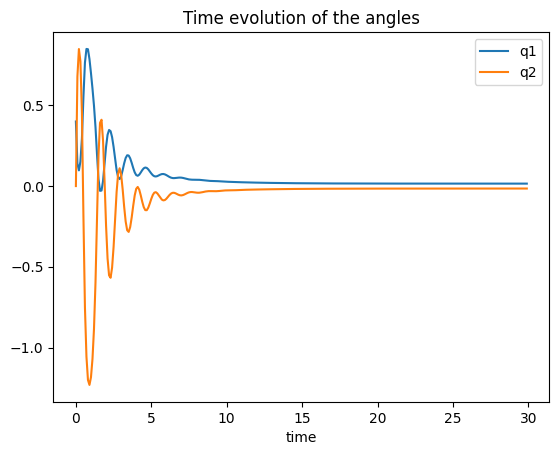

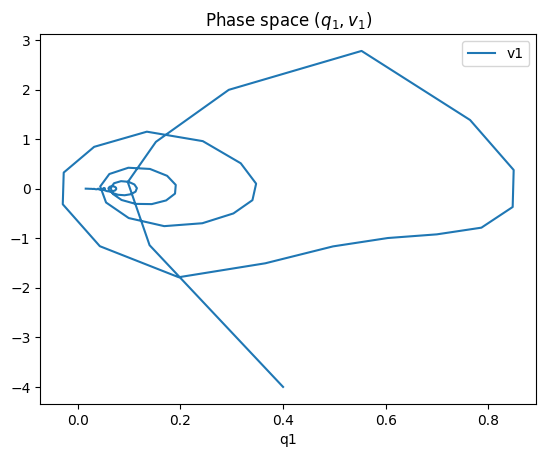

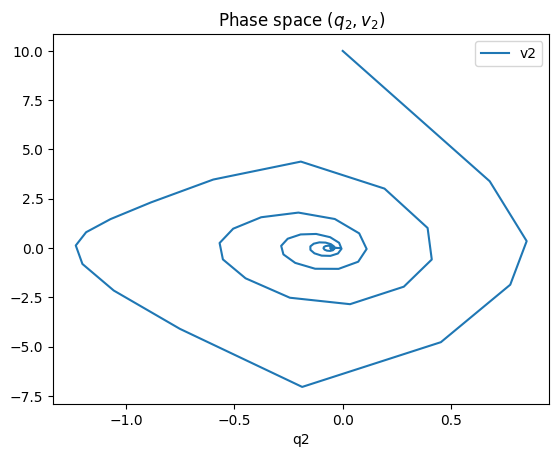

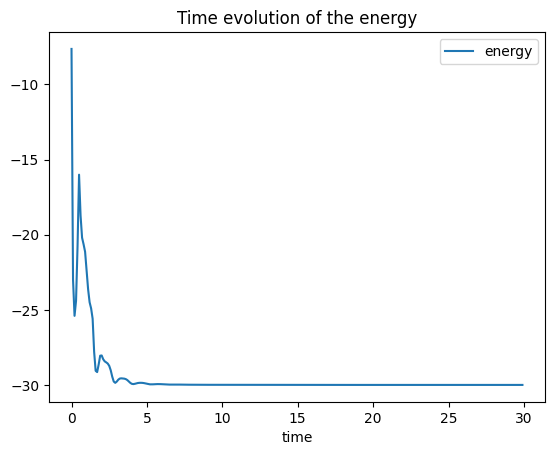

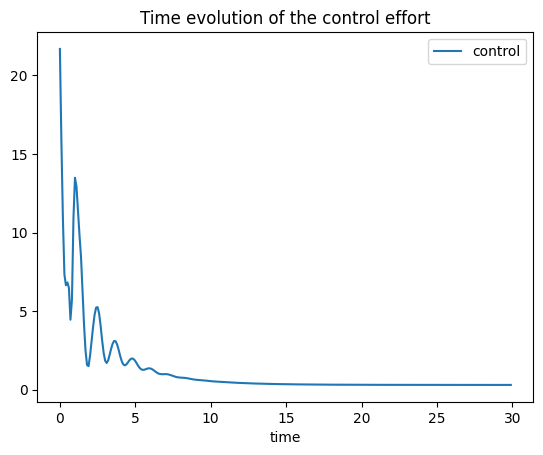

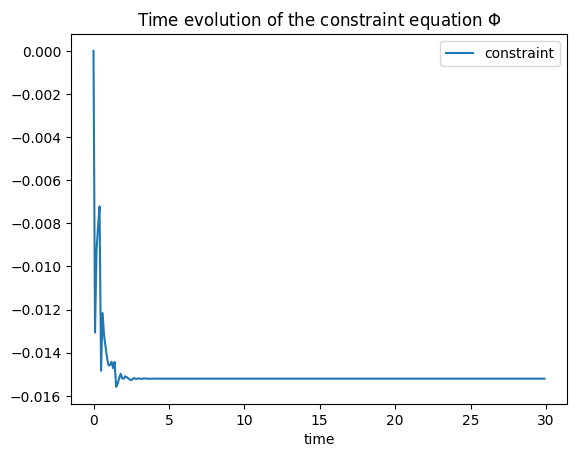

In [6]:
dg.plot(x='time', y=['q1', 'q2'], title='Time evolution of the angles')
dg.plot(x='q1', y='v1', title='Phase space $(q_{1}, v_{1})$')
dg.plot(x='q2', y='v2', title='Phase space $(q_{2}, v_{2})$')
dg.plot(x='time', y='energy', title='Time evolution of the energy')
dg.plot(x='time', y='control', title='Time evolution of the control effort')
dg.plot(x='time', y='constraint', title='Time evolution of the constraint equation $\Phi$')

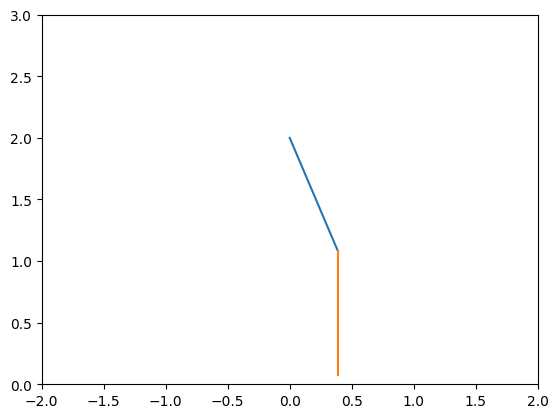

In [7]:
#Make animation
from matplotlib.animation import FuncAnimation, writers
import matplotlib as mpl

fig3 = plt.figure()

lines = plt.plot([])
line = lines[0]
lines2 = plt.plot([])
line2 = lines2[0]
#other setup
plt.xlim(-2, 2)
plt.ylim(0, 3)
# plt.grid()

def animate(k):
    #update plot
    center_x=0
    center_y=2
    x1 = np.array([center_x, center_x + np.sin(X[k,0])])
    y1 = np.array([center_y, center_y - np.cos(X[k,0])])
    x2 = np.array([center_x + np.sin(X[k,0]), center_x + np.sin(X[k,0])+np.sin(X[k,1])])
    y2 = np.array([center_y - np.cos(X[k,0]), center_y - np.cos(X[k,0])-np.cos(X[k,1])])

    line.set_data((x1,y1))
    line2.set_data((x2,y2))

anim = FuncAnimation(fig3,animate,frames=N,interval=N/3)

anim.save('double_pendulum.mp4')